# Measuring the Mass-Ratio Distribution in Real Data
This notebook performs inference on my mass ratio data to estimate mass ratio distribution.

In [1]:
# Imports.
from __future__ import print_function, division, absolute_import

import pandas as pd
from kglib.utils import HelperFunctions, plottools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from astroquery.vizier import Vizier
import logging
from astropy.time import Time 
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('white')

logger = logging.getLogger()
logger.setLevel(logging.WARN)
%matplotlib inline

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Pull out the mass ratio data and completess

In [2]:
from MassRatioDistribution import Hist
import h5py

In [132]:
# List the stars that I believe
good_hipnums = [100221, 100907, 103298, 10732, 109139, 109521, 115115, 12332, 12706, 
                13327, 14043, 14764, 16147, 16244, 16340, 16611, 19949, 20380, 21589, 22833, 22958,
                23362, 24902, 2548, 26126, 32607, 37322, 37450, 38593, 
                38846, 40881, 42129, 46283, 52678, 5310, 72154, 76267, 77336, 
                77516, 78918, 79404, 80460, 82673, 84606, 88116, 88817, 88818, 91118, 93225, 93805]
binary_starlist = ['HIP {}'.format(n) for n in good_hipnums]
binary_starlist.append('HR 545')

# Make a list of the more complicated multiple systems. Exclude for now, but maybe include later...
multiple_hipnums = [13165, 28691, 39847,
                    63945, 74117, 78820, 79199, 96840, 5348]
multiple_starlist = ['HIP {}'.format(n) for n in multiple_hipnums]
multiple_starlist.append('HR 604')
multiple_starlist.append('HR 5605')

# Unconfirmed stars
unconfirmed_hipnums = [13327, 16340, 19949, 23362, 38846, 40881, 72154, 88817]
unconfirmed_starlist = ['HIP {}'.format(n) for n in unconfirmed_hipnums]

In [133]:
len(binary_starlist), len(multiple_starlist)

(51, 11)

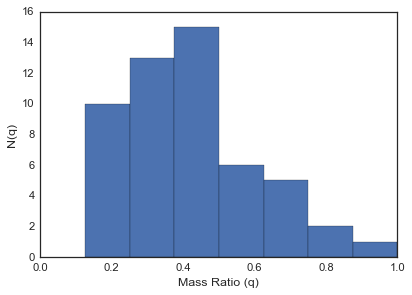

In [42]:
# Read in all of the mass ratio samples
prior_hdf5 = 'data/MassSamples.h5'
with h5py.File(prior_hdf5, 'r') as f:
    q_list = []
    stars = []
    for name, star_grp in f.iteritems():
        starname, component = [s.strip() for s in name.split('-')]
        if starname in binary_starlist:
            M1 = star_grp['primary'].value
            M2_spt = star_grp['companion_spectral_type'].value
            M2_iso = star_grp['companion_isochrone'].value
            if (starname == 'HIP 16611' and np.nanmedian(M2_spt) < 1.2):
                # I don't trust the low-temperature "detection" in this star.
                continue
            
            q_list.append(M2_iso / M1)
            stars.append(starname)
    
    maxsize = max(a.size for a in q_list)
    q = np.ones((len(q_list), maxsize)) * np.nan
    for i, qi in enumerate(q_list):
        q[i][:qi.size] = qi

mean_q = np.nanmedian(q, axis=1)
mean_q = mean_q[~np.isnan(mean_q)]
bins = np.linspace(0, 1.0, 9)
_ = plt.hist(mean_q, bins=bins)
plt.xlabel('Mass Ratio (q)')
plt.ylabel('N(q)')

q[q > 1] = 1.0 / q[q > 1]

# Check which stars were not found
for starname in binary_starlist:
    if starname not in stars:
        print('Did not find data for {}'.format(starname))

In [11]:
# Get completeness
import Completeness
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.interpolate import UnivariateSpline

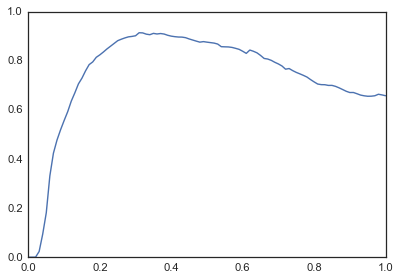

In [138]:
fudge_factor = 0.8   # Reduce the sensitivity to hot companions such that my nondetections are not improbable...

dq = 0.01
comp_q = np.arange(0, 1+dq, dq)
completeness = np.zeros_like(comp_q)
N = np.zeros_like(comp_q)
with h5py.File('data/Completeness.h5', 'r') as f:
    for star, grp in f.iteritems():
        if star not in binary_starlist and star not in multiple_starlist:
            star_completeness = np.zeros((len(grp.keys()), comp_q.size))
            i = 0
            for date, dgrp in grp.iteritems():
                df = Completeness.get_completeness(star.encode(), date.encode()).sort_values(by='q')
                df.loc[df.Temperature > 7000, 'Detection_Rate'] *= fudge_factor
                fcn = spline(df.q, df.Detection_Rate)
                good = (comp_q < df.q.max()) & (comp_q > df.q.min())
                star_completeness[i, good] = fcn(comp_q[good])
                star_completeness[i, comp_q > df.q.max()] = 0.0
                i += 1
                
            completeness += np.max(star_completeness, axis=0)
            N[good] += 1
            
# Set completeness = 0 at q = 0
completeness[0] = 0
N[0] = 1
plt.plot(comp_q, completeness/N)

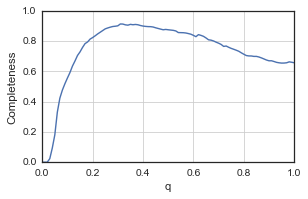

In [139]:
sns.set_context('paper', font_scale=1.3)
smooth_comp_fcn = UnivariateSpline(comp_q, completeness/N, s=0.01)

plt.figure(figsize=(5, 3))
plt.plot(comp_q, completeness/N)
#plt.plot(comp_q, smooth_comp_fcn(comp_q))
plt.xlabel('q')
plt.ylabel('Completeness')
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.grid()
plt.savefig('Figures/SurveyCompleteness.pdf')
plt.savefig('Figures/SurveyCompleteness.png')

# Fit a histogram:

Use the mass-ratio samples and the formalism presented in the paper to fit the data to a histogram. This code accounts for both completeness effects and malmquist bias:

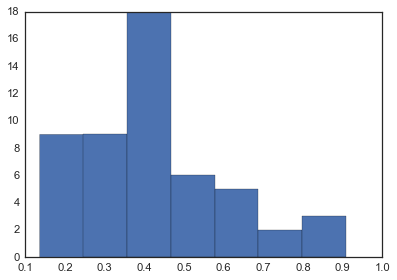

In [123]:
from astropy.visualization import hist
hist(np.nanmean(q, axis=1), bins='freedman')
hist?

In [140]:
import MassRatioDistribution
bins = np.linspace(0, 1, 8)
comp_fcn = spline(comp_q, completeness / N)
class MyFitter(MassRatioDistribution.SmoothHistFitter):
    def __init__(self, *args, **kwargs):
        super(MyFitter, self).__init__(*args, **kwargs)
        #self.malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])
        self.malm_pars = np.array([-0.01309283,  0.02554662, -0.01348757,  0.01048769, -0.0009159 , 0.00729102])
        self.malm_integrals = np.array([self._integrate_malmquist(self.malm_pars[::-1], q0, q1) for 
                                        (q0, q1) in zip(self.bin_edges[:-1], self.bin_edges[1:])])
        self.malm_fcn = np.poly1d(self.malm_pars)
        
    def _integrate_malmquist(self, malm_pars, q0, q1):
        """ Integrate the malmquist-correction factor from q0 --> q1
        """
        return np.sum([p/(i+1.0)*(q1**(i+1.0) - q0**(i+1.0)) for i, p in enumerate(malm_pars)])
    
    def censoring_fcn(self, q):
        return comp_fcn(q)
    
    def lnlike(self, pars):
        # Pull theta out of pars
        theta = pars[:self.Nbins]

        # Generate the inner summation
        gamma = np.ones_like(self.bin_idx) * np.nan
        good = (self.bin_idx < self.Nbins) & (self.bin_idx >= 0)  # nans in q get put in nonexistent bins
        gamma[good] = self.Nobs * self.censoring_fcn(self.qvals[good]) * theta[self.bin_idx[good]]
        
        # Malmquist-correct
        gamma *= self.malm_fcn(self.qvals) / np.sum(theta * self.malm_integrals)

        # Calculate the integral
        I = self._integral_fcn(theta)

        # Generate the log-likelihood
        summation = np.nanmean(gamma, axis=1)
        ll = -I + np.nansum(np.log(summation))
        return ll
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the bins uniformly, making sure they sum to 1
        for i in range(self.Nbins):
            cube[i] *= 10
        norm = np.sum(cube[:self.Nbins] * self.bin_widths)
        for i in range(self.Nbins):
            cube[i] /= norm
        
        # Sample the gaussian process hyperparameters uniformly
        cube[self.Nbins] = cube[self.Nbins] * 40 - 15
        cube[self.Nbins + 1] = cube[self.Nbins + 1] * 40 - 20
        cube[self.Nbins + 2] = cube[self.Nbins + 2] * 7 - 2
        cube[self.Nbins + 3] = cube[self.Nbins + 3] * 30 - 15
        return
    
shf = MyFitter(q, bin_edges=bins)

In [141]:
shf.smoothing = 10.0 # The default value is 6 for this dataset; this makes the smoothing prior somewhat less important

In [142]:
shf.fit_multinest(basename='MCMC_Samples/Fitters/HistFitter/RealData_malmquist_pessimistic_completeness', 
                  overwrite=True)

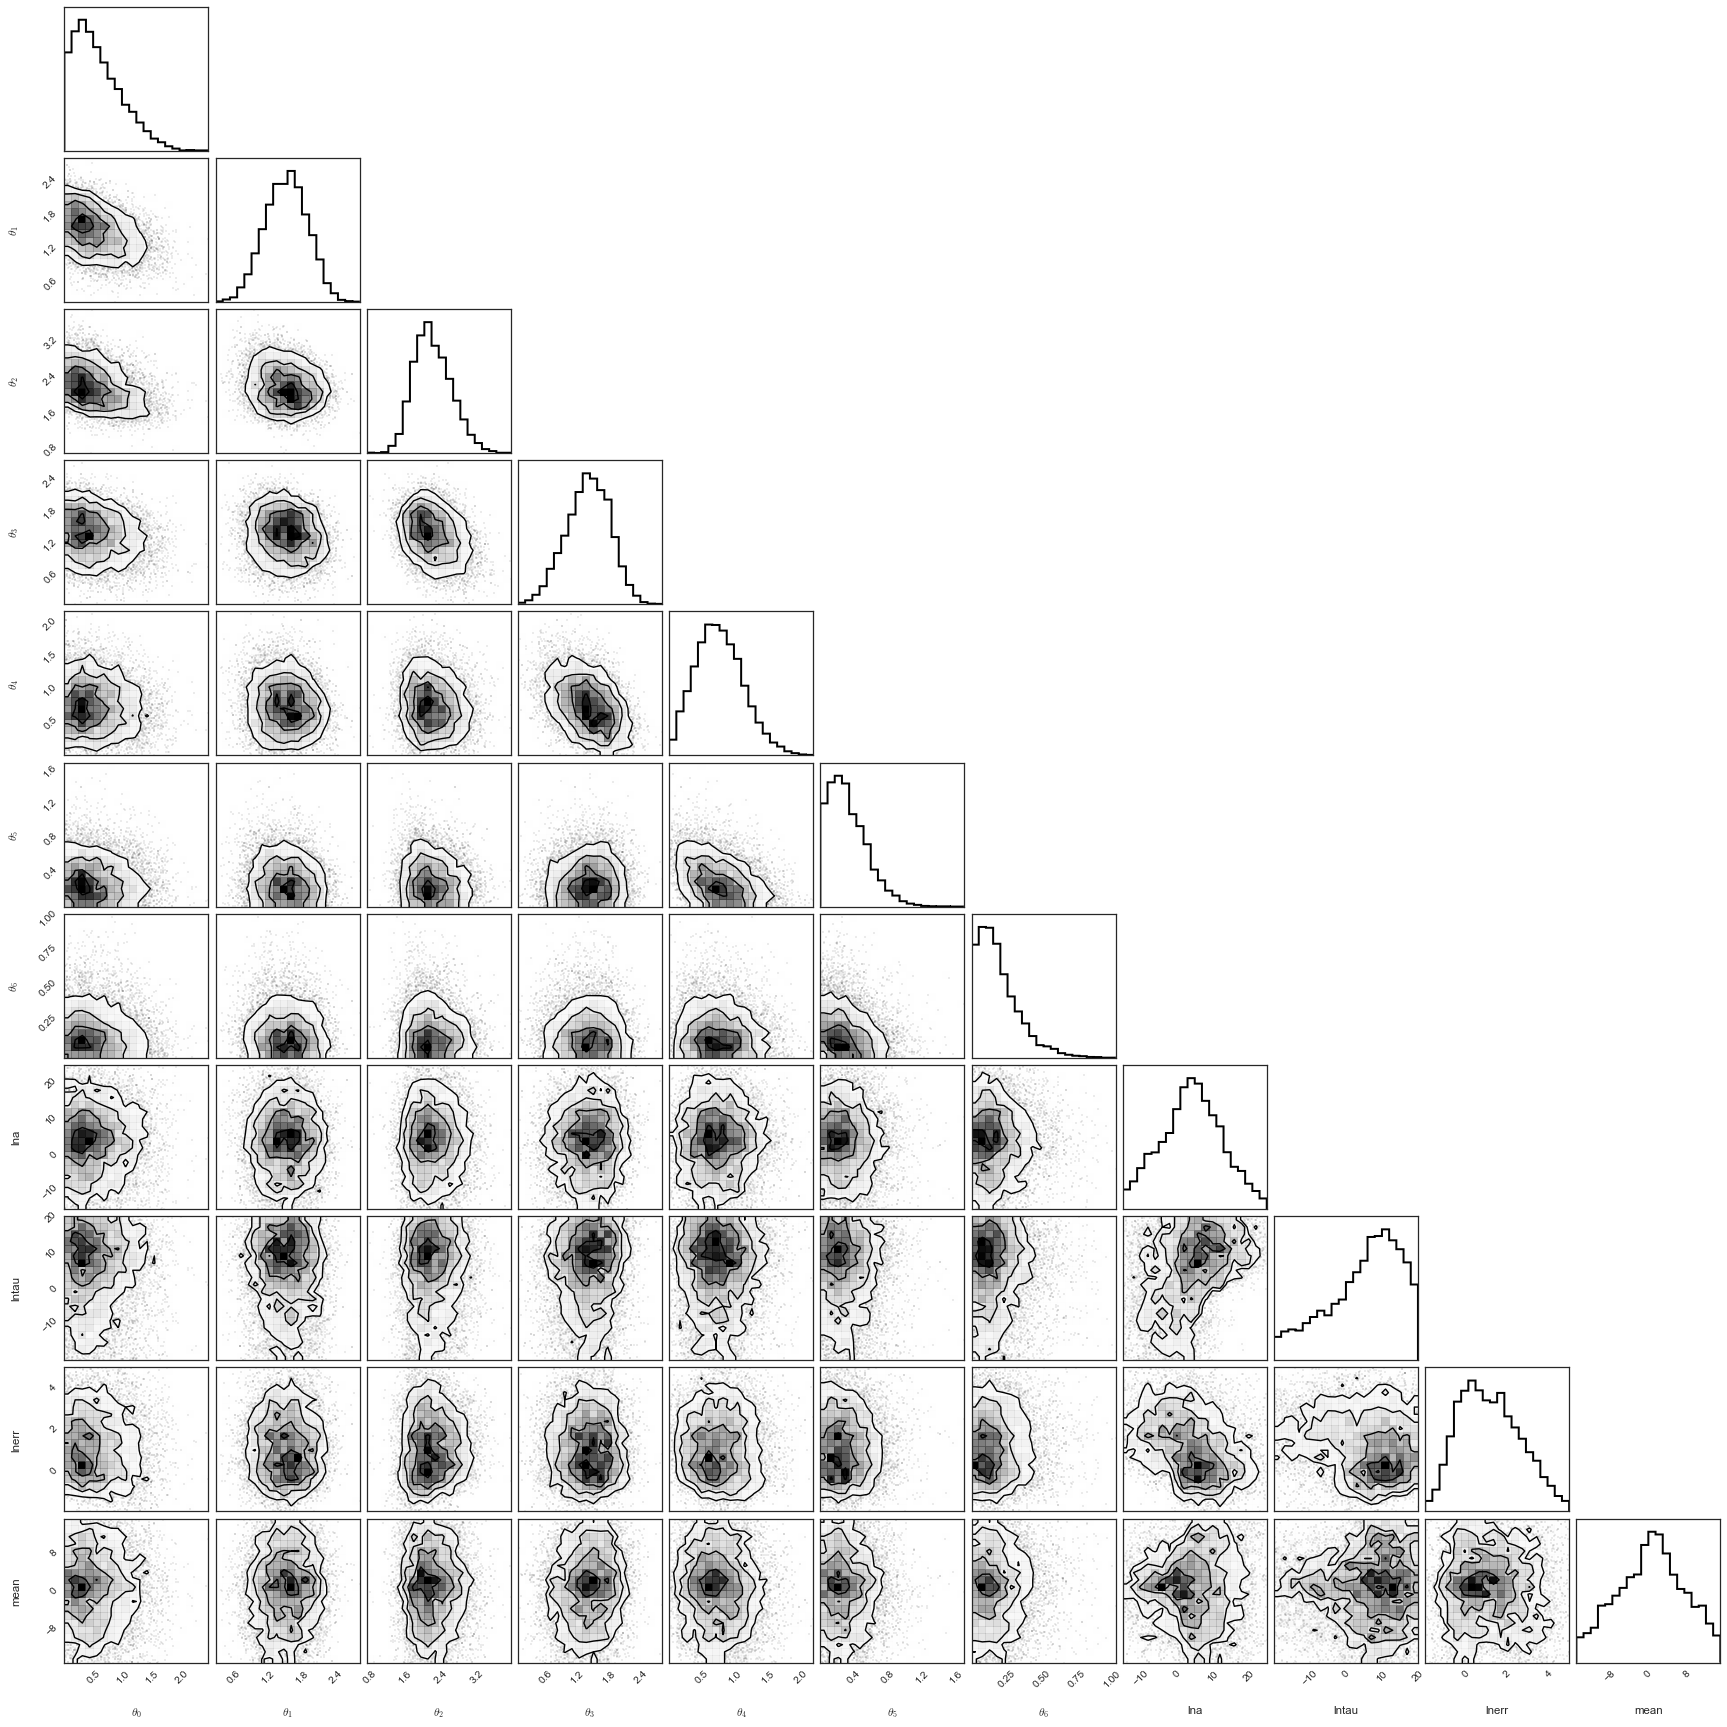

In [143]:
shf.triangle(hist_kwargs=dict(lw=2))

In [144]:
shf.samples.describe()

,$\theta_0$,$\theta_1$,$\theta_2$,$\theta_3$,$\theta_4$,$\theta_5$,$\theta_6$,lna,lnerr,lnprob,lntau,mean
count,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7.828000e+03,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000
mean,0.580791,1.521470,2.211808,1.394952,0.768064,0.328472,1.944423e-01,4.158716,1.159849,167.882966,4.964393,0.547704
std,0.402077,0.365617,0.418084,0.406871,0.360662,0.227082,1.495826e-01,8.336913,1.454819,2.098015,9.845362,6.885075
min,0.000349,0.286127,0.729750,0.078319,0.000268,0.000035,3.275109e-07,-14.962701,-1.994638,152.500767,-19.990539,-14.996386
25%,0.263455,1.269267,1.910377,1.118818,0.504371,0.155274,8.331789e-02,-1.415388,0.021292,166.651421,-1.286145,-4.379991
50%,0.501407,1.530455,2.168410,1.412742,0.743010,0.287342,1.611924e-01,4.222561,1.043541,168.172719,6.980734,0.804623
75%,0.830474,1.776698,2.488572,1.691711,1.006009,0.461819,2.675561e-01,9.878584,2.188038,169.430791,12.661770,5.426904
max,2.455927,2.807174,3.955228,2.786046,2.188193,1.695372,1.027078e+00,24.951532,4.994071,172.172993,19.992213,14.986060


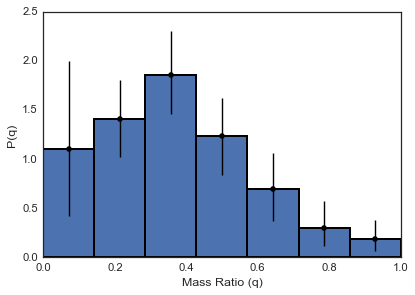

In [192]:
# Completeness-correct the bin heights
samples = shf.samples.copy()
comp_integrals = np.array([quad(comp_fcn, a=low, b=high)[0] for (low, high) in 
                           zip(shf.bin_edges[:-1], shf.bin_edges[1:])])
for i, col in enumerate(shf.param_names[:shf.Nbins]):
    samples[col] /= comp_integrals[i]
    
# Renormalize
norm = np.sum(samples[shf.param_names[:shf.Nbins]].as_matrix() * shf.bin_widths[np.newaxis, :], axis=1)
for i, col in enumerate(shf.param_names[:shf.Nbins]):
    samples[col] /= norm

# Plot the corrected histogram
l, m, h = np.array([np.percentile(samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
bin_heights = m
bin_lowerr = m-l
bin_higherr = h-m
plt.bar(left=bins[:-1], width=shf.bin_widths, height=bin_heights, 
        yerr=(bin_lowerr, bin_higherr), fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, m, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

# Fit the data to a variety of distributions:

In [242]:
from kglib import fitters
from scipy.integrate import quad, romberg, fixed_quad, quadrature
from scipy.special import erf
from scipy.optimize import minimize, minimize_scalar

def get_lognormal_pars(mode, width):
    
    sigma = width
    mu = np.log(mode) + sigma**2
    return mu, sigma

class DistFitter(fitters.Bayesian_LS):
    def __init__(self, qvals):
        self.qvals = qvals
        self.lnq = np.log(qvals)
        self.completeness = self.completeness_fcn(self.qvals)
        self.Nobs = self.qvals.shape[0]
        self.setup_params()
        
        #self.malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])
        self.malm_pars = np.array([-0.01309283,  0.02554662, -0.01348757,  0.01048769, -0.0009159 , 0.00729102])
        self.malm_fcn = np.poly1d(self.malm_pars)
    
    def completeness_fcn(self, q):
        return smooth_comp_fcn(q)
    
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        mu, sigma = pars
        A = 2.0 / (1 - erf(mu / (sigma * np.sqrt(2.0))))
        retval = A / (q * np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (lnq - mu)**2 / sigma**2)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def setup_params(self):
        self.n_params = 2
        self.param_names = [r'$\mu$', r'$\sigma$']
    
    def _integrand(self, q, pars):
        return self.model(q, np.log(q), pars, use_cached_malmint=True) * self.completeness_fcn(q)
    
    def integral_fcn(self, pars):
        retval = quad(self._integrand, a=0, b=1.0, args=pars, maxp1=1000, limit=1000, limlst=1000)
        return retval[0] * self.Nobs
    
    def lnlike(self, pars):
        # Calculate gamma
        gamma = self.completeness * self.model(self.qvals, self.lnq, pars) * self.Nobs
        
        # Make the inner summation
        summand = np.nanmean(gamma, axis=1)
        summation = np.nansum(np.log(summand))
        
        return summation - self.integral_fcn(pars)
    
    def guess_fit_parameters(self, mode=0.4, width=0.3):
        mean, sigma = get_lognormal_pars(mode, width)
        def errfcn(p):
            return -self.lnlike(p)
        
        out = minimize(errfcn, (mean, sigma))
        mean, sigma = out.x
        return mean, sigma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the mean from -3 to 0 
        cube[0] = cube[0] * 3 - 3
        
        # Sample the width from 0.05 to 1
        cube[1] = cube[1] * 0.95 + 0.05
        return
    
    def predict(self, x, N=100, highest=False, malmcorr=False):
        """
        predict the y value for the given x values. Use the N most probable MCMC chains if highest=False,
        otherwise use the first N chains.
        """
        if self.samples is None:
            logging.warn('Need to run the fit method before predict!')
            return

        # Find the N best walkers
        if N == 'all':
            N = self.samples.shape[0]
        else:
            N = min(N, self.samples.shape[0])

        if highest:
            samples = self.samples.sort('lnprob', ascending=False)[:N]
        else:
            indices = np.random.randint(0, self.samples.shape[0], N)
            samples = self.samples.ix[indices]
        
        pars = samples[self.param_names].as_matrix()
        y = np.array([self.model(x, np.log(x), p, malmcorr=malmcorr) for p in pars])
        return y
    
    
    def _malmquist_integral(self, pars, use_cached=False):
        if use_cached:
            return self._malmquist_integral_cache
        else:
            def fcn(q):
                return self.model(q, np.log(q), pars, malmcorr=False) * self.malm_fcn(q)

            out = quad(fcn, a=0, b=1, maxp1=1000, limit=1000, limlst=1000)
            if out[1] / out[0] < 1e-4:
                self._malmquist_integral_cache = out[0]
                return out[0]
            print(pars)
            print(out)
            raise ValueError('Error on integration too large!')

    
class GaussianFitter(DistFitter):
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        mu, sigma = pars
        A = 2.0 / (erf(mu / (sigma * np.sqrt(2))) - erf((mu-1) / (sigma * np.sqrt(2))))
        retval = A / (np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (q - mu)**2 / sigma**2)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, mode=0.4, width=0.3):
        def errfcn(p):
            retval = -self.lnlike(p)
            if np.isinf(retval):
                retval = 9e9
            return retval
        
        out = minimize(errfcn, (mode, width/2.0), bounds=((0, 1), (0.01, 1)))
        mean, sigma = out.x
        return mean, sigma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the mean from 0 to 1 
        cube[0] = cube[0] * 1.0
        
        # Sample the width from 0.01 to 3
        cube[1] = cube[1] * 3 + 0.01
        return
    
    
class PowerLawFitter(DistFitter):
    def setup_params(self):
        self.n_params = 1
        self.param_names = [r'$\gamma$',]
        
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        try:
            gamma = pars[0]
        except (TypeError, IndexError):
            gamma = pars
        #A = 2.0 / (erf(mu / (sigma * np.sqrt(2))) - erf((mu-1) / (sigma * np.sqrt(2))))
        #retval = A / (np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (q - mu)**2 / sigma**2)
        retval = (1-gamma) * q**(-gamma)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, gamma=0):
        def errfcn(p):
            retval = -self.lnlike(p)
            if np.isinf(retval):
                retval = 9e9
            print(p, retval)
            return retval
        
        #out = minimize(errfcn, (gamma,), bounds=((-1, 1),))
        out = minimize_scalar(errfcn, bracket=(-0.5, 0.5), bounds=(-1, 1))
        gamma = out.x
        return gamma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the gamma from -1 to 1 
        cube[0] = cube[0] * 2.0 - 1.0
        
        return
        
    
class BrokenPowerLawFitter(DistFitter):
    def setup_params(self):
        self.n_params = 3
        self.param_names = [r'$\gamma_1$', r'$q_{cut}$', r'$\gamma_2$']
        self.n_params = 2
        self.param_names = [r'$\gamma_1$', r'$\gamma_2$']
        
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        #gamma1, qcut, gamma2 = pars
        gamma1, gamma2 = pars
        logc = np.log((1-gamma1) / (1-gamma2)) / (gamma1 - gamma2)
        qcut = np.exp(logc)
        
        q = np.atleast_1d(q)
        retval = (1-gamma1) * q**(-gamma1)
        if not np.isnan(qcut) and qcut > 0 and qcut < 1:
            retval[q > qcut] = (1-gamma2) * q[q > qcut]**(-gamma2)
            retval /= qcut**(1-gamma1) + (1-qcut**(1-gamma2))
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, gamma=0):
        def errfcn(p):
            retval = -self.lnlike(p)
            if np.isinf(retval):
                retval = 9e9
            print(p, retval)
            return retval
        
        out = minimize(errfcn, (gamma,gamma), bounds=((-1, 1),(-1, 1)))
        #out = minimize_scalar(errfcn, bracket=(-0.5, 0.5), bounds=(-1, 1))
        gamma = out.x
        return gamma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample both gammas from -1 to 1 
        cube[0] = cube[0] * 2.0 - 1.0
        #cube[2] = cube[2] * 2.0 - 1.0
        cube[1] = cube[1] * 2.0 - 1.0
        
        # Sample the cutoff uniformly from 0 to 1 (already done)
        return
    

class UniformFitter(DistFitter):
    def setup_params(self):
        self.n_params = 1
        self.param_names = ['f',]
        
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        try:
            f = pars[0]
        except (TypeError, IndexError):
            f = pars
        #A = 2.0 / (erf(mu / (sigma * np.sqrt(2))) - erf((mu-1) / (sigma * np.sqrt(2))))
        #retval = A / (np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (q - mu)**2 / sigma**2)
        #retval = (1-gamma) * q**(-gamma)
        
        retval = np.copy(q)
        retval[~np.isnan(retval)] = f
        #retval = f
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, f=1.0):
        def errfcn(p):
            retval = -self.lnlike(p)
            if np.isinf(retval):
                retval = 9e9
            #print(p, retval)
            return retval
        
        #out = minimize(errfcn, (gamma,), bounds=((-1, 1),))
        out = minimize_scalar(errfcn, bracket=(0.1, 1), bounds=(1e-3, 10))
        gamma = out.x
        return gamma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the gamma from 0 to 3 
        cube[0] = cube[0] * 3.0
        
        return
    
    
from scipy import special
class BetaFitter(DistFitter):
    def setup_params(self):
        self.n_params = 2
        self.param_names = [r'$\alpha$', r'$\beta$']
    
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        alpha, beta = pars
        A = special.gamma(alpha+beta) / (special.gamma(alpha) * special.gamma(beta))
        retval = A * q**(alpha-1) * (1-q)**(beta-1)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, alpha=5, beta=8):
        def errfcn(p):
            retval = -self.lnlike(p)
            #print(p, retval)
            if np.isinf(retval):
                retval = 9e9
            return retval
        
        out = minimize(errfcn, (alpha, beta), bounds=((0, 25), (0, 25)))
        alpha, beta = out.x
        return alpha, beta
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample alpha from 0 to 25
        cube[0] = cube[0] * 25
        
        # Sample beta from 0 to 25
        cube[1] = cube[1] * 25
        return
    
    
class BetaPlusUniformFitter(DistFitter):
    def setup_params(self):
        self.n_params = 3
        self.param_names = [r'$\alpha$', r'$\beta$', 'logf']
    
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        alpha, beta, logf = pars
        f = 10**logf
        A = 1.0 / ( (special.gamma(alpha) * special.gamma(beta)) / special.gamma(alpha+beta) + f )
        retval = A * ( q**(alpha-1) * (1-q)**(beta-1) + f )
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, alpha=5, beta=8, f=0):
        def errfcn(p):
            retval = -self.lnlike(p)
            #print(p, retval)
            if np.isinf(retval):
                retval = 9e9
            return retval
        
        out = minimize(errfcn, (alpha, beta, f), bounds=((0, 25), (0, 25), (0, 10)))
        alpha, beta = out.x
        return alpha, beta
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample alpha from 0 to 25
        cube[0] = cube[0] * 25
        
        # Sample beta from 0 to 25
        cube[1] = cube[1] * 25
        
        # Sample logf from -10 to 1
        cube[2] = cube[2] * 11 - 10
        return
    
    
class IMFFitter(DistFitter):
    def __init__(self, *args, **kwargs):
        super(IMFFitter, self).__init__(*args, **kwargs)
        import dill
        with open('Kroupa_MRD.dill', 'r') as infile:
            self.kroupa_mrd = dill.load(infile)
        
    def setup_params(self):
        self.n_params = 0
        self.param_names = []
    
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        if isinstance(q, np.ndarray) and len(q.shape) > 1: 
            retval = np.array([self.kroupa_mrd(q[i]) for i in range(q.shape[0])])
        else:
            retval = self.kroupa_mrd(q)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval

## Normal distribution

In [243]:
# Helper Function
def fit_data(function='gaussian', *args, **kwargs):
    if function.lower() == 'gaussian':
        df = GaussianFitter(q)
    elif function.lower() == 'lognormal':
        df = DistFitter(q)
    elif function.lower() == 'power':
        df = PowerLawFitter(q)
    elif function.lower() == 'broken-power':
        df = BrokenPowerLawFitter(q)
    elif function.lower() == 'uniform':
        df = UniformFitter(q)
    elif function.lower() == 'beta':
        df = BetaFitter(q)
    elif function.lower() == 'beta2':
        df = BetaPlusUniformFitter(q)
    
    df.fit_multinest(*args, **kwargs)
    df.triangle(hist_kwargs=dict(lw=2))
    return df

  analysing data from MCMC_Samples/Fitters/GaussianFitter/RealData_malmquist_pessimistic.txt
log evidence = 165.0486 +/- 0.01155


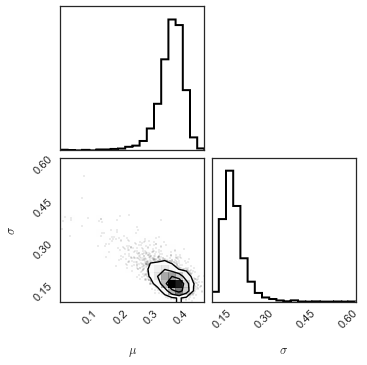

In [202]:
df = fit_data(function='gaussian',
              basename='MCMC_Samples/Fitters/GaussianFitter/RealData_malmquist_pessimistic', 
              overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

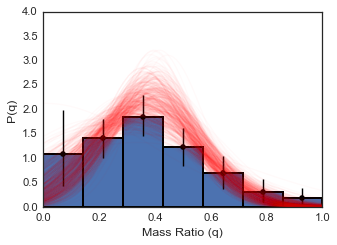

In [203]:
sns.set_context('paper', font_scale=1.4)

fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

#l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
ax.bar(left=bins[:-1], width=shf.bin_widths, height=bin_heights, 
        yerr=(bin_lowerr, bin_higherr), fill=True, lw=2, ecolor='k')
ax.plot(shf.bin_centers, bin_heights, 'ko')
ax.set_xlabel('Mass Ratio (q)')
ax.set_ylabel('P(q)')

qvals = np.linspace(0, 1, 100)
#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=ax, color='red', alpha=0.02)

ax.set_ylim((0, 4.0))
fig.savefig('Figures/MRD_normal.pdf')
fig.savefig('Figures/MRD_normal.png')

In [196]:
df.samples.describe()

,$\mu$,$\sigma$,lnprob
count,3919.000000,3919.000000,3919.000000
mean,0.365315,0.193270,170.189394
std,0.045768,0.039413,1.234115
min,0.001879,0.113354,160.307197
25%,0.345673,0.167293,169.759840
50%,0.372699,0.186041,170.578308
75%,0.393939,0.209941,171.054131
max,0.493501,0.508896,171.390267


## Power law

  analysing data from MCMC_Samples/Fitters/PowerLawFitter/RealData_malmquist_pessimistic.txt
log evidence = 152.1368 +/- 0.01027


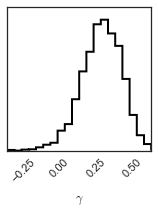

In [197]:
df = fit_data(function='power',
              basename='MCMC_Samples/Fitters/PowerLawFitter/RealData_malmquist_pessimistic', 
              overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

In [198]:
l, m, h = np.percentile(df.samples['$\gamma$'].values, [16, 50, 84])
print(m, h-m, m-l)
print(df.samples.loc[np.argmax(df.samples.lnprob), '$\gamma$'])
df.samples.describe()

0.295338361798 0.126292446585 0.140484493492
0.320555451464


,$\gamma$,lnprob
count,2763.000000,2763.000000
mean,0.288252,153.402538
std,0.137454,0.707877
min,-0.360830,146.286669
25%,0.201223,153.260871
50%,0.295338,153.677184
75%,0.387071,153.837079
max,0.631690,153.888436


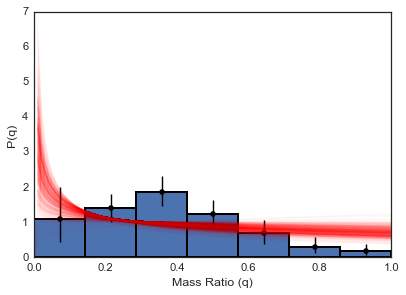

In [200]:
#l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
#plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
#l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=bin_heights, 
        yerr=(bin_lowerr, bin_higherr), fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, bin_heights, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_powerlaw.pdf')
plt.savefig('Figures/MRD_powerlaw.png')

# Broken Power Law

  analysing data from MCMC_Samples/Fitters/BrokenPowerLawFitter/RealData_malmquist_pessimistic.txt
log evidence = 158.6757 +/- 0.04136


,$\gamma_1$,$\gamma_2$,lnprob
count,4100.000000,4100.000000,4100.000000
mean,-0.731920,0.776622,161.286671
std,0.215319,0.096506,1.170585
min,-0.999978,0.150999,153.395243
25%,-0.901925,0.726283,160.763971
50%,-0.783393,0.794236,161.568857
75%,-0.610086,0.846507,162.138387
max,0.347324,0.947543,162.703444


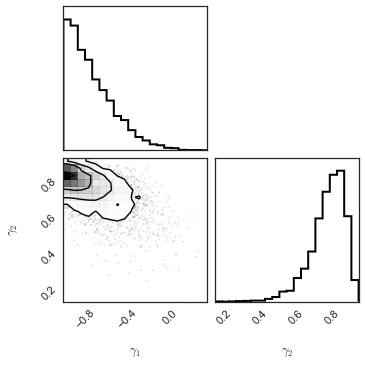

In [244]:
df = fit_data(function='broken-power',
              basename='MCMC_Samples/Fitters/BrokenPowerLawFitter/RealData_malmquist_pessimistic', 
              overwrite=True)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))
df.samples.describe()

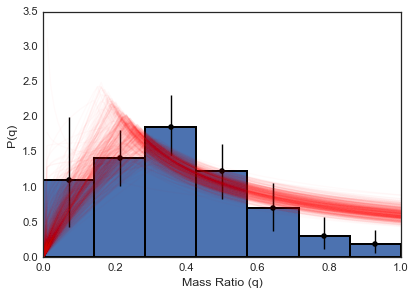

In [245]:
plt.bar(left=bins[:-1], width=shf.bin_widths, height=bin_heights, 
        yerr=(bin_lowerr, bin_higherr), fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, bin_heights, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_powerlaw.pdf')
plt.savefig('Figures/MRD_powerlaw.png')

## Lognormal Distribution

  analysing data from MCMC_Samples/Fitters/LogNormalFitter/RealData_malmquist_pessimistic.txt
log evidence = 167.5892 +/- 0.01641


,$\mu$,$\sigma$,lnprob,max
count,3791.000000,3791.000000,3791.000000,3791.000000
mean,-0.989284,0.469065,171.055465,0.298222
std,0.076444,0.075120,1.145527,0.029237
min,-1.292895,0.299643,162.516482,0.147491
16%,-1.061645,0.398832,170.030465,0.269969
50%,-0.992892,0.457662,171.420683,0.300646
84%,-0.918937,0.535414,172.010585,0.326918
max,-0.465987,0.914425,172.211931,0.379053


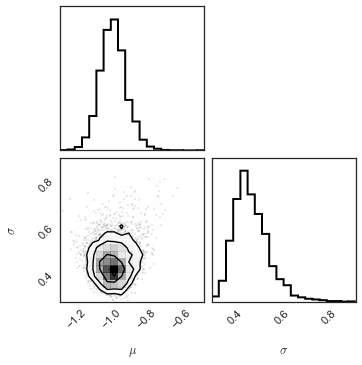

In [272]:
df = fit_data(function='lognormal',
              basename='MCMC_Samples/Fitters/LogNormalFitter/RealData_malmquist_pessimistic', 
              overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))
df.samples['max'] = np.exp(df.samples['$\mu$'] - df.samples['$\sigma$']**2)
df.samples.describe(percentiles=[0.16, 0.50, 0.84])

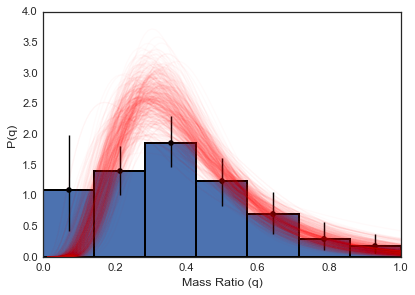

In [255]:
plt.bar(left=bins[:-1], width=shf.bin_widths, height=bin_heights, 
        yerr=(bin_lowerr, bin_higherr), fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, bin_heights, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_lognormal.pdf')
plt.savefig('Figures/MRD_lognormal.png')

In [257]:
np.percentile(np.exp(df.samples['$\mu$']), [16, 50, 84])

array([ 0.34538093,  0.37034494,  0.39880929])

## Uniform Distribution.
Since everything is normalized, this has no parameters and the evidence integral is just the likelihood function evaluated with height = 1.0

In [156]:
df = UniformFitter(q)
df.lnlike(1)

151.82127502909839

## Beta Distribution

  analysing data from MCMC_Samples/Fitters/BetaFitter/RealData_malmquist_pessimistic.txt
log evidence = 166.3176 +/- 0.01205


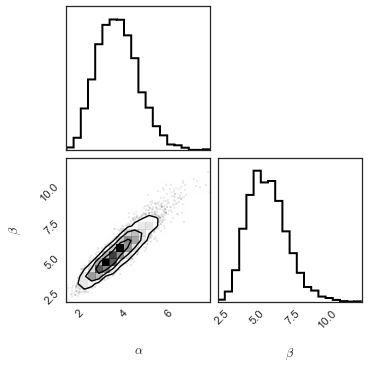

In [204]:
df = fit_data(function='beta',
              basename='MCMC_Samples/Fitters/BetaFitter/RealData_malmquist_pessimistic', 
              overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

In [205]:
alpha = df.samples[r'$\alpha$']
beta = df.samples[r'$\beta$']
df.samples['Max'] = (alpha-2) / (beta-2) / (1 + (alpha-2) / (beta-2))
df.samples.describe(percentiles=[0.16, 0.50, 0.84])

,$\alpha$,$\beta$,lnprob,Max
count,3664.000000,3664.000000,3664.000000,3664.000000
mean,3.727831,5.719801,170.636912,0.315272
std,0.938344,1.383989,1.039804,1.258517
min,1.380202,2.169275,162.697428,-1.755989
16%,2.793276,4.339513,169.783861,0.237651
50%,3.667172,5.610872,170.941841,0.313355
84%,4.639632,7.051690,171.527001,0.361415
max,7.908304,12.410363,171.720909,76.170646


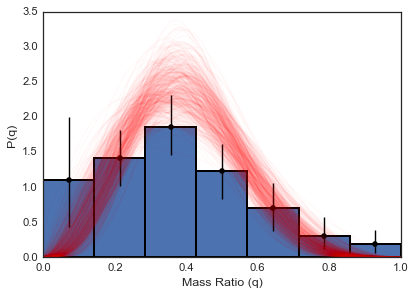

In [206]:
#l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
#plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), 
#        label='DFM Histogram', fill=True, lw=2, ecolor='k')
#plt.plot(shf.bin_centers, m, 'ko')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=bin_heights, 
        yerr=(bin_lowerr, bin_higherr), fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, bin_heights, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_beta.pdf')
plt.savefig('Figures/MRD_beta.png')

## Beta function + Uniform

  analysing data from MCMC_Samples/Fitters/BetaPlusUniformFitter/RealData_malmquist_pessimistic.txt
log evidence = 166.7699 +/- 0.06860


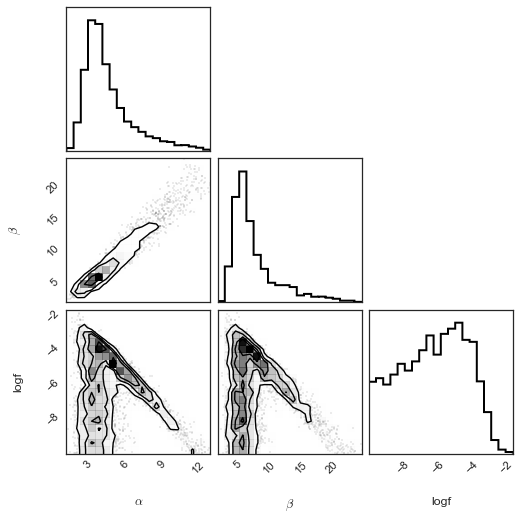

In [207]:
df = fit_data(function='beta2',
              basename='MCMC_Samples/Fitters/BetaPlusUniformFitter/RealData_malmquist_pessimistic', 
              overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

In [162]:
alpha = df.samples[r'$\alpha$']
beta = df.samples[r'$\beta$']
df.samples['Max'] = (alpha-2) / (beta-2) / (1 + (alpha-2) / (beta-2))
df.samples.describe(percentiles=[0.16, 0.50, 0.84])

,$\alpha$,$\beta$,lnprob,logf,Max
count,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000
mean,4.663884,7.587331,170.662561,-6.290195,0.301903
std,2.051320,3.757266,1.104527,1.922173,0.149565
min,1.444313,2.337079,161.805203,-9.999044,-3.037934
16%,2.984917,4.690212,169.669710,-8.571154,0.254362
50%,4.052727,6.304899,170.968668,-6.162980,0.316116
84%,6.418500,10.978263,171.606512,-4.197403,0.358655
max,13.261781,23.945050,172.128583,-2.002567,6.965015


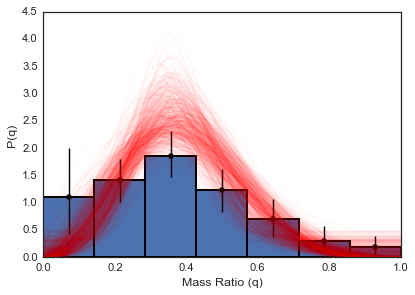

In [209]:
#l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
#plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
#plt.plot(shf.bin_centers, m, 'ko')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=bin_heights, 
        yerr=(bin_lowerr, bin_higherr), fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, bin_heights, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=750, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_beta2.pdf')
plt.savefig('Figures/MRD_beta2.png')

In [164]:
# Compare to Kroupa IMF:
df = IMFFitter(q)
ll = df.lnlike([])
print(ll)  # This is the evidence for the Kroupa IMF (compare to the evidences quoted above)

115.055538881


# Everything Plot
Make a plot similar to the beta distribution one, but also overplot the best-fit power law and the Kroupa IMF fit.

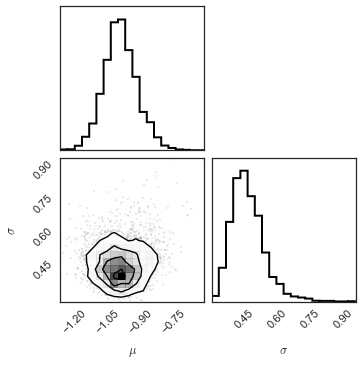

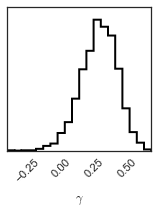

In [259]:
best_gamma = 0.360744
imf_fitter = IMFFitter(q)

#beta_fitter = fit_data(function='beta',
#                        basename='MCMC_Samples/Fitters/BetaFitter/RealData_malmquist_pessimistic', overwrite=False)
lognormal_fitter = fit_data(function='lognormal',
                            basename='MCMC_Samples/Fitters/LogNormalFitter/RealData_malmquist_pessimistic',
                            overwrite=False)
powerlaw_fitter = fit_data(function='power',
                           basename='MCMC_Samples/Fitters/PowerLawFitter/RealData_malmquist_pessimistic',
                           overwrite=False)

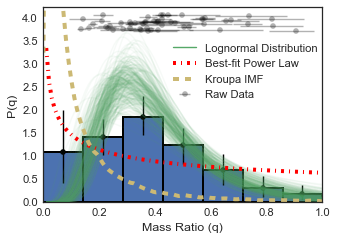

In [270]:
sns.set_context('paper', font_scale=1.4)
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

# Plot the histogram
#l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
ax.bar(left=bins[:-1], width=shf.bin_widths, height=bin_heights, 
        yerr=(bin_lowerr, bin_higherr), fill=True, lw=2, ecolor='k')
ax.plot(shf.bin_centers, bin_heights, 'ko')
ax.set_xlabel('Mass Ratio (q)')
ax.set_ylabel('P(q)')

# Plot the beta distribution samples
colors = sns.color_palette()
lognormal_fitter.plot_samples(qvals, N=300, ax=ax, color=colors[1], alpha=0.05)
ax.plot([], [], color=colors[1], label='Lognormal Distribution')

# Plot the power law
#powerlaw_fitter.plot_samples(qvals, N=500, ax=ax, color='red', alpha=0.02)
#ax.plot([], [], color='red', label='Power Law')

# Plot the power law and IMF
ax.plot(qvals, (1-best_gamma) * qvals**(-best_gamma), label='Best-fit Power Law', lw=4, color='red', ls='-.')
ax.plot(qvals, imf_fitter.kroupa_mrd(qvals), label='Kroupa IMF', lw=4, color=colors[4], ls='--')

# Plot the raw data
l, m, h = np.nanpercentile(q, [16, 50, 84], axis=1).T
q_data = m
q_lowerr = m-l
q_uperr = h-m
dx = 0.2
y_mean = 3.9
yvals = np.random.uniform(low=y_mean-dx, high=y_mean+dx, size=q_data.shape)
ax.errorbar(q_data, yvals, xerr=(q_lowerr, q_uperr), fmt='ko', alpha=0.3, label='Raw Data')
#plt.ylim((0, 4.5))

#leg = ax.legend(loc='best', fancybox=True)
leg = ax.legend(loc=(0.45, 0.5), fancybox=True)
ax.set_ylim((0, 4.25))
plt.savefig('Figures/MRD_total.pdf')
plt.savefig('Figures/MRD_total.png')

In [261]:
lognormal_fitter.plot_samples?

# TODO: try showing samples from the power law instead of the 'peaky' function

# How unlikely is the difference between my results and VAST?
Sample from the q distributions for my data, and compare to 19 stars in the close-by VAST sample. I will only include stars from my sample with mean $q > 0.15$, above which the completeness is roughly constant.

In [228]:
import scipy.stats
vast_qvals = np.array([0.32, 0.18, 0.58, 0.57, 0.44, 0.49, 0.25, 0.74, 
                       0.99, 0.23, 0.18, 0.71, 0.44, 0.39, 0.99, 0.83, 
                       1, 0.27, 0.72])

In [229]:
good_idx = np.nanmean(q, axis=1) > 0.15
high_q = q[good_idx]
def get_ks_stat():
    N = high_q.shape[0]
    my_qvals = np.zeros(N)
    for i in range(N):
        done = False
        while not done:
            done = True
            q = np.random.choice(high_q[i])
            if np.isnan(q):
                done = False
        my_qvals[i] = q
    
    #return scipy.stats.ks_2samp(vast_qvals, my_qvals)
    return scipy.stats.anderson_ksamp((get_vast_q(), my_qvals))

def get_vast_q(err=0.05):
    """ Sample VAST q by assuming uncertainties of 0.05"""
    a, b = (-vast_qvals) / err, (1-vast_qvals) / err
    return np.array([scipy.stats.truncnorm.rvs(a[i], b[i], loc=vast_qvals[i], scale=err) for i in range(len(vast_qvals))])

In [230]:
N = 100000
p_value = np.zeros(N)
for i in range(N):
    ks, _, p = get_ks_stat()
    p_value[i] = p

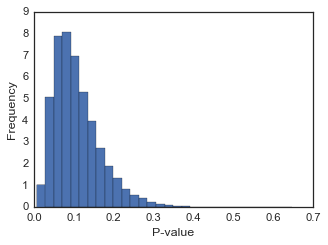

In [231]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
bins = 30
ax.hist(p_value, bins=bins, normed=True)

ax.set_xlabel('P-value')
ax.set_ylabel('Frequency')
fig.savefig('Figures/VAST_pval.pdf')
fig.savefig('Figures/VAST_pval.png')

In [238]:
# Summarize the p-value
l, m, h = np.percentile(p_value, [16, 50, 84])
print('p = {:.3f} +{:.3f} / -{:.3f}'.format(m, h-m, m-l))

p = 0.096 +0.067 / -0.042
